## Fit betas using pyhrf for imagery_rf_2014 data



In [ ]:
# %pylab inline
# %load_ext autoreload
# %autoreload 2

In [1]:
import hrf_fitting.src.preprocessing as preproc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import nibabel as nib
import pickle
import matplotlib.animation as animation
import hrf_estimation as he
import operator

from PIL import Image
from hrf_fitting.src.features import construct_placement_grid,make_kernel_grid,complex_ripple_filter,compute_grid_corners
from scipy.signal import convolve2d
from os import path
from sklearn import linear_model
from glob import glob
from sklearn.metrics import explained_variance_score,r2_score
from scipy.stats.mstats import zscore
from joblib import Parallel, delayed
from time import time
from scipy.interpolate import griddata

Populating the interactive namespace from numpy and matplotlib


### Select data

In [2]:
subject = 'TN'
db =  '/musc.repo/Data/nickdesisto/Imagery_DB-updated.csv'
state_list = ['pcp', 'img']

import into pandas dataframe and view it

In [3]:
data_db = pd.io.parsers.read_csv(db,header=0)
data_db

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,run_type,design matrix,frame_file,...,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol,mag,phase,anatomical
0,0,8/7/2014,CO,imagery.rf,/musc.repo/Data/nickdesisto/Imagery preprocced...,/musc.repo/Data/nickdesisto/Imagery preprocced...,1,1pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,NaN,NaN,NaN
1,1,8/7/2014,CO,imagery.rf,/musc.repo/Data/nickdesisto/Imagery preprocced...,/musc.repo/Data/nickdesisto/Imagery preprocced...,1,1img,design_matrix.npy,img_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,NaN,NaN,NaN
2,2,8/7/2014,CO,imagery.rf,/musc.repo/Data/nickdesisto/Imagery preprocced...,/musc.repo/Data/nickdesisto/Imagery preprocced...,1,2pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,NaN,NaN,NaN
3,3,8/7/2014,CO,imagery.rf,/musc.repo/Data/nickdesisto/Imagery preprocced...,/musc.repo/Data/nickdesisto/Imagery preprocced...,1,2img,design_matrix.npy,img_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,NaN,NaN,NaN
4,4,8/7/2014,CO,imagery.rf,/musc.repo/Data/nickdesisto/Imagery preprocced...,/musc.repo/Data/nickdesisto/Imagery preprocced...,1,3pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,NaN,NaN,NaN
5,5,8/7/2014,CO,imagery.rf,/musc.repo/Data/nickdesisto/Imagery preprocced...,/musc.repo/Data/nickdesisto/Imagery preprocced...,1,3img,design_matrix.npy,img_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,NaN,NaN,NaN
6,6,8/7/2014,CO,imagery.rf,/musc.repo/Data/nickdesisto/Imagery preprocced...,/musc.repo/Data/nickdesisto/Imagery preprocced...,1,4pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,NaN,NaN,NaN
7,7,8/7/2014,CO,imagery.rf,/musc.repo/Data/nickdesisto/Imagery preprocced...,/musc.repo/Data/nickdesisto/Imagery preprocced...,1,4img,design_matrix.npy,img_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,NaN,NaN,NaN
8,8,9/7/2014,CO,imagery.rf,/musc.repo/Data/nickdesisto/Imagery preprocced...,/musc.repo/Data/nickdesisto/Imagery preprocced...,2,5pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,NaN,NaN,NaN
9,9,9/7/2014,CO,imagery.rf,/musc.repo/Data/nickdesisto/Imagery preprocced...,/musc.repo/Data/nickdesisto/Imag

### Specify runs for training and testing the model

In [4]:
def get_rows_with(db, col,col_contains):
    '''
    get_rows_with(col,col_contains)
    returns index of all stimuli with "col_contains" in the stim_column
    example: all imagery runs = get_stimuli_with('run', 'img')
    '''
    row_func = lambda row: col_contains in row
    return db.loc[db[col].apply(row_func),:]

subj_db = get_rows_with(data_db, 'subject', 'TN')

In [5]:
subj_db

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,run_type,design matrix,frame_file,...,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol,mag,phase,anatomical
33,33,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,5pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
34,34,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,5img,design_matrix.npy,img_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
35,35,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,6pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
36,36,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,6img,design_matrix.npy,img_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
37,37,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,7pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
38,38,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,7img,design_matrix.npy,img_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
39,39,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,8pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris.

In [6]:
idx = {}
for state in state_list:
    idx[state] = get_rows_with(subj_db, 'run_type', state).index.tolist()


In [7]:
data_db.iloc[idx['pcp']]

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,run_type,design matrix,frame_file,...,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol,mag,phase,anatomical
33,33,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,5pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
35,35,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,6pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
37,37,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,7pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
39,39,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,8pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
41,41,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,5,1pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
43,43,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,6,1pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/home/nick/ichi/musc.repo/Data/nickdesisto/ana...
45,45,7/7/2014,TN,imagery.rf,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,/musc.repo/Data/nickdesisto/Imagery_preproc/Al...,6,2pcp,design_matrix.npy,pcp_frame_list.txt,...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,run_experiment.py,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,/musc.repo/mri/7T.cmrr/Presentation/imagery.rf...,0,0,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris...,/mnt/7T_Imagery/July.2014.Imagery.RF/Naselaris.

### Load neural data

In [8]:
brain_vols = {}
##note: load_runs uses "iloc" to grab rows, in which case we must use data_db
##when usin "loc" to grab rows, we can use either data_db or subj_db
for state in state_list:
    brain_vols[state] = preproc.load_runs(data_db, idx[state])
    

detrending run 0 with window_length: 153
detrending run 1 with window_length: 155
detrending run 2 with window_length: 155
detrending run 3 with window_length: 153
detrending run 4 with window_length: 153
detrending run 5 with window_length: 153
detrending run 6 with window_length: 155
detrending run 7 with window_length: 153
detrending run 8 with window_length: 155
detrending run 9 with window_length: 151
detrending run 10 with window_length: 159
detrending run 11 with window_length: 151
detrending run 12 with window_length: 159
zscoring 0 thru 306
zscoring 306 thru 616
zscoring 616 thru 925
zscoring 925 thru 1231
zscoring 1231 thru 1535
zscoring 1535 thru 1839
zscoring 1839 thru 2147
zscoring 2147 thru 2451
zscoring 2451 thru 2759
zscoring 2759 thru 3059
zscoring 3059 thru 3376
zscoring 3376 thru 3676
zscoring 3676 thru 3993
detrending run 0 with window_length: 153
detrending run 1 with window_length: 155
detrending run 2 with window_length: 155
detrending run 3 with window_length: 1

Reshape, mask, and remove inf's. Need to add this functionality to "load_runs"

In [23]:
##optional axial slice selection
first_slice,last_slice = 0,-1

##note: we use state[0] here because we expect vols for all states to have same dimensions
bm = data_db.loc[idx[state_list[0]]]['brain_mask'].tolist()[0]

#first the mask. mucked up the database somehow, so reading in the brain mask is a stupid mess
# bm = glob('/media'+data_db.iloc[art_runs[0]]['brain_mask'].split('/media')[2]+'/*.gz')

mask_image = nib.load(bm).get_data().astype('bool') ##a numpy boolean

##now some indices for coronal slicing.
zdx = np.zeros(brain_vols[state_list[0]].shape[0:3]).astype('bool')
zdx[:,:,first_slice:last_slice] = True

##can't use any of the voxels with knackered values
finite_voxels = np.isfinite(brain_vols[state_list[0]].get_data()).all(axis=3)*np.isfinite(brain_vols[state_list[0]].get_data()).all(axis=3)

mask_image = mask_image*zdx*finite_voxels

In [24]:
def apply_mask(vol,raveled_mask):
    vol = vol.get_data().reshape((np.prod(vol.shape[0:3]),vol.shape[3])).T  ##converts to (time, xyz)
    return vol[:,raveled_mask]
    

In [25]:
##test masking
mean_vol = preproc.load_runs(data_db,idx[state_list[0]][0:2],detrend=False,z_score=False)
mean_vol = apply_mask(mean_vol,mask_image.ravel()).mean(axis=0)
test_view = np.zeros(mask_image.shape).ravel()
test_view[mask_image.ravel()] = mean_vol
test_view = test_view.reshape(mask_image.shape)

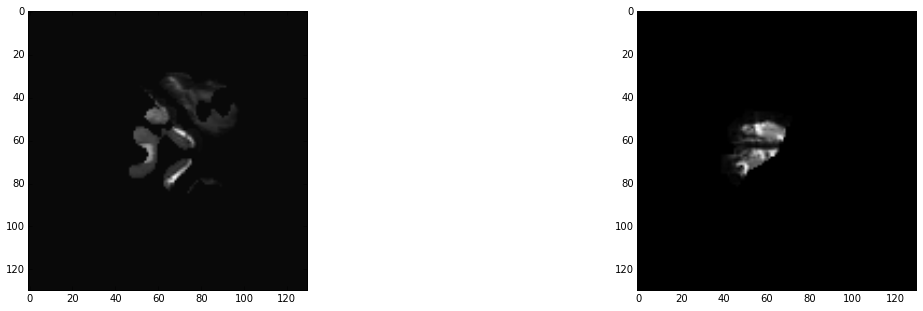

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(test_view[:,:,first_slice],cmap=cm.gray)
plt.subplot(1,2,2)
plt.imshow(test_view[:,:,last_slice-1],cmap=cm.gray)

In [27]:
for state in state_list:
    brain_vols[state] = apply_mask(brain_vols[state],mask_image.ravel())
    print 'vol dimensions for state %s: %s' %(state, (brain_vols[state].shape,))

vol dimensions for state pcp: ((3993, 427199),)
vol dimensions for state img: ((4297, 427199),)


### Construct conditions matrices
Note that chunkwise_downsampling not needed here because the chunksize is 1.

In [28]:
frame_lists = {}
for state in state_list:
    frame_lists[state] = []
    for _,row in data_db.iloc[idx[state]].iterrows():
        frame_lists[state].append(preproc.load_frame_file(row))

In [29]:
##check
for state in state_list:
    print len(frame_lists[state][0])
    print len(np.unique(frame_lists[state][0]))
    print frame_lists[state][0][100:121]

6120
65
['003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', '003206.004.00.image.png', 'rest_frame_0.png']
6120
65
['003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png', '003206.004.00.cue.png

In [30]:
downsampled_frame_lists = {}
for state in state_list:
    downsampled_frame_lists[state] = []
    for fl in frame_lists[state]:
        downsampled_frame_lists[state].append(preproc.chunkwise_downsampling(fl,20,rule='first'))


In [31]:
TR = data_db.loc[idx[state], 'TR'].unique()[0]
hrf_length = 10 ##in TR's
condition_map = {}
condition_sequence = {}
condition_onsets = {}
conditions_matrix = {}
for state in state_list:
    flattened_list = [it for fl in downsampled_frame_lists[state] for it in fl]
    condition_map[state], condition_sequence[state], condition_onsets[state],conditions_matrix[state] = preproc.construct_conditions_matrix(flattened_list,TR,hrf_length,not_a_condition =['rest_frame_0.png'])

In [40]:
for state in state_list:
    print len(condition_sequence[state])
    print len(condition_onsets[state])
    print len(condition_map[state])

1664
1664
512
1792
1792
512


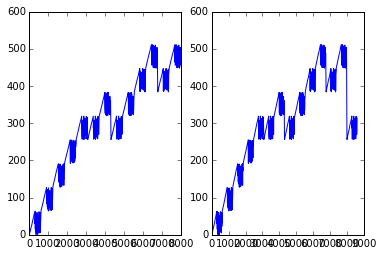

In [33]:
fig = plt.figure()
for ii,state in enumerate(state_list):
    plt.subplot(1,len(state_list),ii+1)
    plt.plot(condition_onsets[state],condition_sequence[state])

dimensions should be: 3993 x 5120
dimensions are:       3993 x 5120
dimensions should be: 4297 x 5120
dimensions are:       4297 x 5120


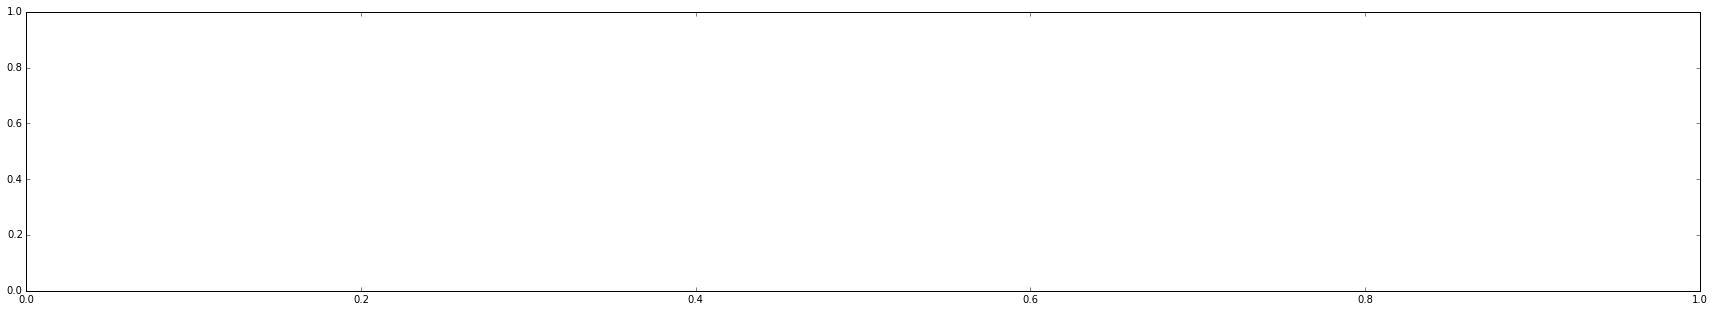

In [36]:
fig = plt.figure(figsize=(30,10))
for ii,state in enumerate(state_list):
    plt.subplot(len(state_list),1,ii+1)
    plt.imshow(conditions_matrix[state], cmap=cm.hot)
    plt.axes().set_aspect(1/6.)
    print 'dimensions should be: %d x %d' %(data_db.loc[idx[state],'nvols'].sum(), len(data_db.loc[idx[state], 'run_type'].unique())*64*hrf_length)
    print 'dimensions are:       %d x %d' %(conditions_matrix[state].shape[0],conditions_matrix[state].shape[1])


In [43]:
brain_vols[state].shape[1]

427199

In [48]:
# we construct the matrix of drifts as the matrix of ones that account for
# the intercept term. If you have drifts estimated by e.g. SPM you can add
# them here.
hrfs= {}
betas = {}
for state in state_list:
    drifts = np.ones((brain_vols[state].shape[0], 1))

    ##fit this! 
    hrfs[state], betas[state] = he.glm(condition_sequence[state],
                                       condition_onsets[state],
                                       float(TR),
                                       brain_vols[state],
                                       drifts=drifts, mode='r1glm', basis='3hrf', verbose=1, n_jobs = 4)
    
    print '=============dimensions of betas for %s: %d x %d' %(state, betas[state].shape[0],betas[state].shape[1])

.. creating design matrix ..
.. done creating design matrix ..
.. computing initialization ..
.. done initialization ..
=============dimensions of betas for pcp: 512 x 427199
.. creating design matrix ..
.. done creating design matrix .... completed 500 out of 106800 ..
.. completed 500 out of 106800 ..
.. completed 500 out of 106800 ..
.. completed 500 out of 106799 ..
.. completed 1000 out of 106800 .... completed 1000 out of 106800 .... completed 1000 out of 106800 .... completed 1000 out of 106799 ..



.. completed 1500 out of 106800 .... completed 1500 out of 106800 .... completed 1500 out of 106800 .... completed 1500 out of 106799 ..



.. completed 2000 out of 106800 .... completed 2000 out of 106800 .... completed 2000 out of 106800 .... completed 2000 out of 106799 ..



.. completed 2500 out of 106800 .... completed 2500 out of 106800 .... completed 2500 out of 106800 .... completed 2500 out of 106799 ..



.. completed 3000 out of 106800 .... completed 3000 out of 106800 .

ValueError: array must not contain infs or NaNs

> /home/tnaselar/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py(668)asarray_chkfinite()
    667         raise ValueError(
--> 668             "array must not contain infs or NaNs")
    669     return a





.. completed 33000 out of 106800 .... completed 33000 out of 106800 .... completed 33000 out of 106800 .... completed 33000 out of 106799 ..



.. completed 33500 out of 106800 .... completed 33500 out of 106800 .... completed 33500 out of 106800 .... completed 33500 out of 106799 ..



.. completed 34000 out of 106800 .... completed 34000 out of 106800 .... completed 34000 out of 106800 .... completed 34000 out of 106799 ..



.. completed 34500 out of 106800 .... completed 34500 out of 106800 .... completed 34500 out of 106800 .... completed 34500 out of 106799 ..



.. completed 35000 out of 106800 .... completed 35000 out of 106800 .... completed 35000 out of 106800 .... completed 35000 out of 106799 ..



.. completed 35500 out of 106800 .... completed 35500 ou

In [ ]:
fig = plt.figure(figsize=(30,10))
for ii,state in enumerate(state_list):
    plt.subplot(len(state_list),1,ii+1)
    _=plt.hist(betas[state].ravel(),100,log=True)

In [ ]:
fig = plt.figure(figsize=(30,10))
generated_hrfs = {}
xx = np.linspace(0, 25) # range of values for time
for ii,state in enumerate(state_list):
    # construct the final HRF by multiplying by its basis
    generated_hrfs[state] = hrfs[state][0] * he.hrf.spmt(xx)[:, None] + hrfs[state][1] * he.hrf.dspmt(xx)[:, None] + hrfs[state][2] * he.hrf.ddspmt(xx)[:, None]
    random_voxels = np.random.randint(0,high=hrfs[state].shape[1],size=100)
    plt.subplot(len(state_list),1,ii+1)
    plt.plot(xx, generated_hrfs[state][:,random_voxels])
    plt.ylim((-.5, 1.))
    plt.show()

In [ ]:
brain_view = np.zeros(mask_image.shape).ravel()
brain_view[mask_image.ravel()] = mean_vol
brain_view = brain_view.reshape(mask_image.shape)


In [ ]:
brain_view.shape 

In [ ]:
beta_view = {}
for state in state_list:
    beta_view[state] = np.zeros((mask_image.ravel().shape)+(betas[state].shape[0],))
    print beta_view[state].shape

    for b in range(betas[state].shape[0]):
        beta_view[state][mask_image.ravel(),b] = betas[state][b,:].T

    beta_view[state] = beta_view[state].reshape(mask_image.shape+(betas[state].shape[0],))
    print beta_view[state].shape
    nib.save(nib.Nifti1Image(beta_view[state],affine=np.eye(4)),'/media/tnaselar/Data/scratch/pyhrf_'+subject+'_'+state+'_beta_view.nii')

In [ ]:
nib.save(nib.Nifti1Image(brain_view,affine=np.eye(4)),'/media/tnaselar/Data/scratch/pyhrf_'+subject+'_brain_view.nii')